<a href="https://colab.research.google.com/github/manasc12/Road_Mishap_Risk_Analysis_Using_Machine_Learning_and_Deep_Learning/blob/master/Pipeline_Implementation_Randomforest_5_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing Randomforest with Pipeline
### Importing Required Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion,make_pipeline,Pipeline
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
# from sklearn.base import BaseEstimator, TransformerMixin

<h3> Reading the Data from CSV file </h3>
<h4>1. Accident Data
<br>3. Vehicles Data

In [ ]:
df_Acc=pd.read_csv('/content/drive/My Drive/data/dftRoadSafetyData_Accidents_2018.csv')
df_Veh=pd.read_csv('/content/drive/My Drive/data/dftRoadSafetyData_Vehicles_2018.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_All=pd.merge(df_Acc,df_Veh,how='inner',on=['Accident_Index'])

### Creating the Estimator functions and building Pipeline

In [ ]:
### Function for cleaning null valued rows
def cleanNullRows(X,y):
    X=X[~X.isnull().any(axis=1)]
    y=y[y.index.isin(X.index)]
    return X,y


### Function for sampling the data set
def sampling(X,y):
    return RandomOverSampler(random_state=42).fit_sample(X, y)


### Function and FunctionTransform to convert the 'Time' feature 
def addTime_Conv(X):
    a= np.array([(int(str(x).split(':')[0])*60+int(str(x).split(':')[1])) for x in X['Time'].values])
    X_=X.copy()
    X_['Time_Conv']=a
    return X_
time_conv_transformer=FunctionTransformer(addTime_Conv)


### Function and FunctionTransform for Feature selection
def dropFeatures(X):
    X_=X.copy()
    return X_[['Time_Conv', 'Location_Easting_OSGR', 'Longitude', 'Latitude',
       'LSOA_of_Accident_Location', 'Location_Northing_OSGR',
       'Local_Authority_(District)', '1st_Road_Number', 'Age_of_Driver',
       'Engine_Capacity_(CC)', 'Local_Authority_(Highway)',
       'Number_of_Vehicles', 'Day_of_Week', 'Speed_limit', 'Vehicle_Type',
       'Vehicle_Manoeuvre', 'Age_of_Vehicle', '1st_Road_Class',
       'Junction_Detail', 'Urban_or_Rural_Area', 'Age_Band_of_Driver',
       'Driver_IMD_Decile', 'Vehicle_IMD_Decile']]
dropFeat_transformer=FunctionTransformer(dropFeatures)


### Creating transformer functions for LabelEncoder as it doesnt support ColumnTransformer
class ModifiedLabelEncoderLSOA(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit(df_All[df_All['LSOA_of_Accident_Location'].notna()]['LSOA_of_Accident_Location']).transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)


class ModifiedLabelEncoderHighWay(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit(df_All[df_All['Local_Authority_(Highway)'].notna()]['Local_Authority_(Highway)']).transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

### Creating ColumnTransformer for the features having 'str' data
labelEncode_transformer=ColumnTransformer(remainder='passthrough',transformers=[('Lblencoder_LSOA',ModifiedLabelEncoderLSOA(),['LSOA_of_Accident_Location'])
                                                                                ,('Lblencoder_Highway',ModifiedLabelEncoderHighWay(),['Local_Authority_(Highway)'])])



###Creating Pipeline
pre_process=Pipeline(steps=[('time_conv_transformer',time_conv_transformer),('dropFeat_transformer',dropFeat_transformer),('labelEncode_transformer',labelEncode_transformer)],)
pipeline1=Pipeline(steps=[('pre_process',pre_process),('RandomForestClassifier',RandomForestClassifier(n_estimators=50))])

### Splitting up the training and Testing Data for Our Pipeline

In [ ]:
target_c=['Accident_Severity']
X=df_All.drop(target_c,axis=1)
y=df_All[target_c]

X,y=cleanNullRows(X,y)
X,y=sampling(X,y)


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)


### Calling fit and predict methods for our Pipeline

In [ ]:
pipeline1.fit(X_train,y_train)
y_pred=pipeline1.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [ ]:
accuracy_score(y_test,y_pred)

0.9759374594524458

### Visualizing our created Pipeline

In [ ]:
from sklearn import set_config
set_config(display='diagram')   
pipeline1  

Pipeline(steps=[('pre_process',
                 Pipeline(steps=[('time_conv_transformer',
                                  FunctionTransformer(func=<function addTime_Conv at 0x7f682d2e86a8>)),
                                 ('dropFeat_transformer',
                                  FunctionTransformer(func=<function dropFeatures at 0x7f682dcd0ea0>)),
                                 ('labelEncode_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Lblencoder_LSOA',
                                                                   ModifiedLabelEncoderLSOA(),
                                                                   ['LSOA_of_Accident_Location']),
                                                                  ('Lblencoder_Highway',
                                                                   ModifiedLabelEncoderHighWay(),
                                                                   ['Local_Authority_(Highway)'])]))])),
                ('RandomForestClassifier',
                 RandomForestClassifier(n_estimators=50))])

#### Plot Confusion Matrix and other relevant Evaluation Criteria

In [ ]:
def plot_confusion_matrix(actual_target_list,predicted_target_list,classes_list,axis_notation_list=[]):
    if len(axis_notation_list)==0:
      axis_notation_list=classes_list
    conf_mat=[]
    actual_target_list=list(actual_target_list)
    for aclass in classes_list:
        row_list=[]
        for pclass in classes_list:
            row_list.append(sum(pd.Series(predicted_target_list)[pd.Series(actual_target_list)==aclass]==pclass))
        conf_mat.append(row_list)
    hw=len(classes_list)*1.5
    fig, ax = plt.subplots(figsize=(hw,hw/2))
    heatmap=sns.heatmap(conf_mat,
            xticklabels=axis_notation_list,yticklabels=axis_notation_list,
            annot=True,cbar=False,ax=ax,fmt='g',cmap='Blues',
                       linewidths=0.3, linecolor='black')


    ax.set(xlabel='Predicted',ylabel='Actual')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    plt.show()
    return conf_mat

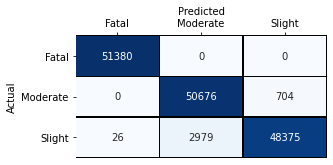

[[51380, 0, 0], [0, 50676, 704], [26, 2979, 48375]]

In [ ]:
plot_confusion_matrix(y_test.to_numpy().reshape(len(y_test),).tolist(),y_pred,[1,2,3],['Fatal','Moderate','Slight'])